<a href="https://colab.research.google.com/github/Aruna-Jayarajan/Satelite_Network/blob/main/GNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import load_model
from torch_geometric.loader import DataLoader as PyGDataLoader
import torch.nn.functional as F


# Add src/ to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Project modules
from dataloader import SatelliteDataset, NUM_GATEWAYS
from model import Stage2GNN
from train import train_model_with_mse
from utils import plot_metrics


In [ ]:

# ========== Load Dataset ==========
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
file_list = sorted([
    os.path.join(DATA_FOLDER, f)
    for f in os.listdir(DATA_FOLDER)
    if f.endswith('.csv')
])[:10]

train_size = int(0.8 * len(file_list))
train_files, val_files = file_list[:train_size], file_list[train_size:]

train_dataset = SatelliteDataset(train_files)
val_dataset = SatelliteDataset(val_files)

train_loader = PyGDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"✅ Loaded {len(train_files)} training files and {len(val_files)} validation files.")

# ========== Load Stage 1 Model ==========
STAGE1_MODEL_PATH = 'stage_1_model.h5'
stage1_model = load_model(STAGE1_MODEL_PATH)

# ========== Build GNN Model ==========
input_dim = 3 + NUM_GATEWAYS * 3  # pos + visible + top3 + neighbor
gnn_model = Stage2GNN(
    input_dim=input_dim,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS,
    dropout=0.3,
    use_residual=True
)

optimizer_gnn = optim.Adam(gnn_model.parameters(), lr=0.001)

# ========== Train ==========
results = train_model_with_mse(
    gnn_model=gnn_model,
    stage1_model=stage1_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer_gnn=optimizer_gnn,
    num_epochs=10,
    rounds=15
)


(train_losses, val_losses,
 train_top1_acc, train_top3_acc, train_top5_acc,
 val_top1_acc, val_top3_acc, val_top5_acc) = results

# ========== Plot ==========
plot_metrics(train_losses, val_losses,
             train_top1_acc, train_top3_acc, train_top5_acc,
             val_top1_acc, val_top3_acc, val_top5_acc)

# ========== Save ==========
torch.save(gnn_model.state_dict(), 'stage2_loop_gnn_model.pth')
print("✅ GNN model saved.")


Testing

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model

from dataloader import prepare_input_for_gnn, build_graph_from_file
from utils import top_k_accuracy
from model import Stage2GNN

# Paths
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'  # Trained with MSE

# Load models
stage1_model = load_model(STAGE1_MODEL_PATH)

# Define GNN model (match architecture from training)
input_dim = 3 + NUM_GATEWAYS * 3
gnn_model = Stage2GNN(input_dim=input_dim, sat_feature_dim=111,
                      neighbor_feature_dim=NUM_GATEWAYS, hidden_dim=256, output_dim=NUM_GATEWAYS)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# Prepare test files (files 100 to 105)
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
test_files = file_list[100:105]

# Build PyG Data objects
test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

# Evaluate
total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0
predictions = []

with torch.no_grad():
    for data in test_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

        # Convert to binary
        binary_preds_model1 = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_model1):
            binary_preds_model1[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))
        preds = gnn_model(gnn_input.x, gnn_input.edge_index)

        # Accuracy calculation
        total_top1 += top_k_accuracy(preds, data.y, k=1)
        total_top3 += top_k_accuracy(preds, data.y, k=3)
        total_top5 += top_k_accuracy(preds, data.y, k=5)
        total_samples += 1

        # Optional: store for inspection
        top1_pred = torch.topk(preds, k=1, dim=1).indices.squeeze().tolist()
        for i in range(len(data.y)):
            predictions.append([data.y[i].item(), top1_pred[i]])

# Print final accuracy
print("\n===== FINAL TEST ACCURACY (5 FILES) =====")
print(f"Top-1 Accuracy: {total_top1 / total_samples:.4f}")
print(f"Top-3 Accuracy: {total_top3 / total_samples:.4f}")
print(f"Top-5 Accuracy: {total_top5 / total_samples:.4f}")

# Optional: Save predictions
results_df = pd.DataFrame(predictions, columns=["Ground Truth", "Top-1 Prediction"])
results_df.to_csv("test_results_mse.csv", index=False)
print("\nSaved predictions to test_results_mse.csv")


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



===== FINAL TEST ACCURACY (5 FILES) =====
Top-1 Accuracy: 0.3395
Top-3 Accuracy: 0.7205
Top-5 Accuracy: 0.8434

Saved predictions to test_results_mse.csv


In [3]:
import pandas as pd
df = pd.read_csv("test_results_mse.csv")
df.head()


,Ground Truth,Top-1 Prediction
0,20,10
1,53,0
2,5,3
3,30,52
4,36,45


Lets try including cells now shall we?

In [23]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model import Stage2GNN

# === Paths ===
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'

# === Load Data ===
cells_df = pd.read_csv(cells_path)
original_df = pd.read_csv(data_file)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === Prepare Graph ===
graph = build_graph_from_file(data_file)
data_loader = DataLoader([graph], batch_size=1)

# === Setup ===
unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
sat_to_indices = defaultdict(list)
for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
    sat_to_indices[feed_sat].append(row_idx)

satellite_to_gateway = {}
gateway_to_sats = defaultdict(list)
cell_to_gateways = {}  # index → [closest, second]
for idx, row in cells_df.iterrows():
    cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

# === Model Inference ===
top1_preds = []
with torch.no_grad():
    for data in data_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

        binary_preds = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_indices):
            binary_preds[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
        gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
        top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

        for row_idx, gateway in enumerate(top1_preds):
            feed_sat = original_df.iloc[row_idx]["feed_sat"]
            satellite_to_gateway[feed_sat] = gateway
            gateway_to_sats[gateway].append(feed_sat)

# === Fair Cell Assignment (Greedy) ===
satellite_to_cells = defaultdict(list)
assigned_cells = set()
used_gateways = set()

for gw, sats in gateway_to_sats.items():
    nearby_cells = cells_df[
        (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
    ].index.tolist()

    if not sats or not nearby_cells:
        continue

    used_gateways.add(gw)
    sats = list(set(sats))  # Remove dups
    n_sats = len(sats)
    cell_chunks = np.array_split(nearby_cells, n_sats)

    for sat, chunk in zip(sats, cell_chunks):
        for cell in chunk:
            if cell not in assigned_cells:
                satellite_to_cells[sat].append(cell)
                assigned_cells.add(cell)

# === Summary ===
total_unique_sats = len(unique_sats)
total_cells = len(cells_df)
all_gateways = set(range(NUM_GATEWAYS))

assigned_sat_ids = set(satellite_to_cells.keys())
unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
unused_gateways = sorted(all_gateways - used_gateways)
unassigned_cells = sorted(set(cells_df.index) - assigned_cells)

# === Summary ===
print("\n=== Summary ===")
print(f"Unique Satellites: {total_unique_sats}")
print(f"Satellites With Assigned Cells: {len(assigned_sat_ids)} ({len(assigned_sat_ids) / total_unique_sats * 100:.2f}%)")
print(f"Satellites With No Assigned Cells: {len(unassigned_sat_ids)} ({len(unassigned_sat_ids) / total_unique_sats * 100:.2f}%)")

print(f"Gateways With Unassigned Cells: {len(unused_gateways)} ({len(unused_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Total Gateways: {NUM_GATEWAYS}")
print(f"Used Gateways: {len(used_gateways)} ({len(used_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Unused Gateways: {unused_gateways}")

print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({len(assigned_cells) / total_cells * 100:.2f}%)")
print(f"Unassigned Cells: {len(unassigned_cells)} ({len(unassigned_cells) / total_cells * 100:.2f}%)")

# === Export Results ===
# === Export Results ===
output_rows = []
all_sat_ids = sorted(feed_sat_to_id.keys())  # Include all satellites, not just assigned ones

for sat_feed_val in all_sat_ids:
    row_indices = sat_to_indices.get(sat_feed_val, [])
    predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
    most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
    assigned = satellite_to_cells.get(sat_feed_val, [])

    # Convert np.int64 values to int
    assigned_clean = [int(cell) for cell in assigned]

    actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
    actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

    output_rows.append({
        "unique_satellite_id": sat_feed_val,
        "predicted_gateway": most_common_gateway,
        "actual_gateway_id": actual_gateway,
        "assigned_cells": assigned_clean,
        "actual_cell_ids": actual_cell_ids
    })

output_df = pd.DataFrame(output_rows)
output_df.to_csv("satellite_to_cells_mapping.csv", index=False)

# === Output preview ===
print("\n=== Output File Preview ===")
print(output_df.head())


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



=== Summary ===
Unique Satellites: 112
Satellites With Assigned Cells: 96 (85.71%)
Satellites With No Assigned Cells: 16 (14.29%)
Gateways With Unassigned Cells: 15 (27.78%)
Total Gateways: 54
Used Gateways: 39 (72.22%)
Unused Gateways: [1, 4, 8, 11, 15, 19, 22, 23, 26, 31, 32, 35, 46, 51, 52]
Assigned Cells: 4296 / 4569 (94.02%)
Unassigned Cells: 273 (5.98%)

=== Output File Preview ===
   unique_satellite_id  predicted_gateway  actual_gateway_id  \
0                    5                  2                  2   
1                    7                 34                 34   
2                    8                 29                 29   
3                   28                  3                  2   
4                   29                  6                 21   

                                      assigned_cells  \
0                     [2183, 2332, 3221, 3637, 3638]   
1  [1, 45, 101, 143, 176, 193, 219, 222, 242, 251...   
2  [92, 108, 163, 212, 303, 375, 440, 536, 598, 7...   

Small test to see unique feed_sats

In [12]:
import pandas as pd

# Path to your input file
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"

# Load the full data
df = pd.read_csv(data_file)

# Group by unique feed_sat and extract the first lat/lon per satellite
unique_sat_info = (
    df[['feed_sat', 'Latitude', 'Longitude']]
    .drop_duplicates(subset='feed_sat')
    .sort_values(by='feed_sat')
    .reset_index(drop=True)
)

# Save to CSV
output_file = "unique_feed_sats_with_location.csv"
unique_sat_info.to_csv(output_file, index=False)

print(f"Saved {len(unique_sat_info)} unique satellites with location to {output_file}")


Saved 112 unique satellites with location to unique_feed_sats_with_location.csv


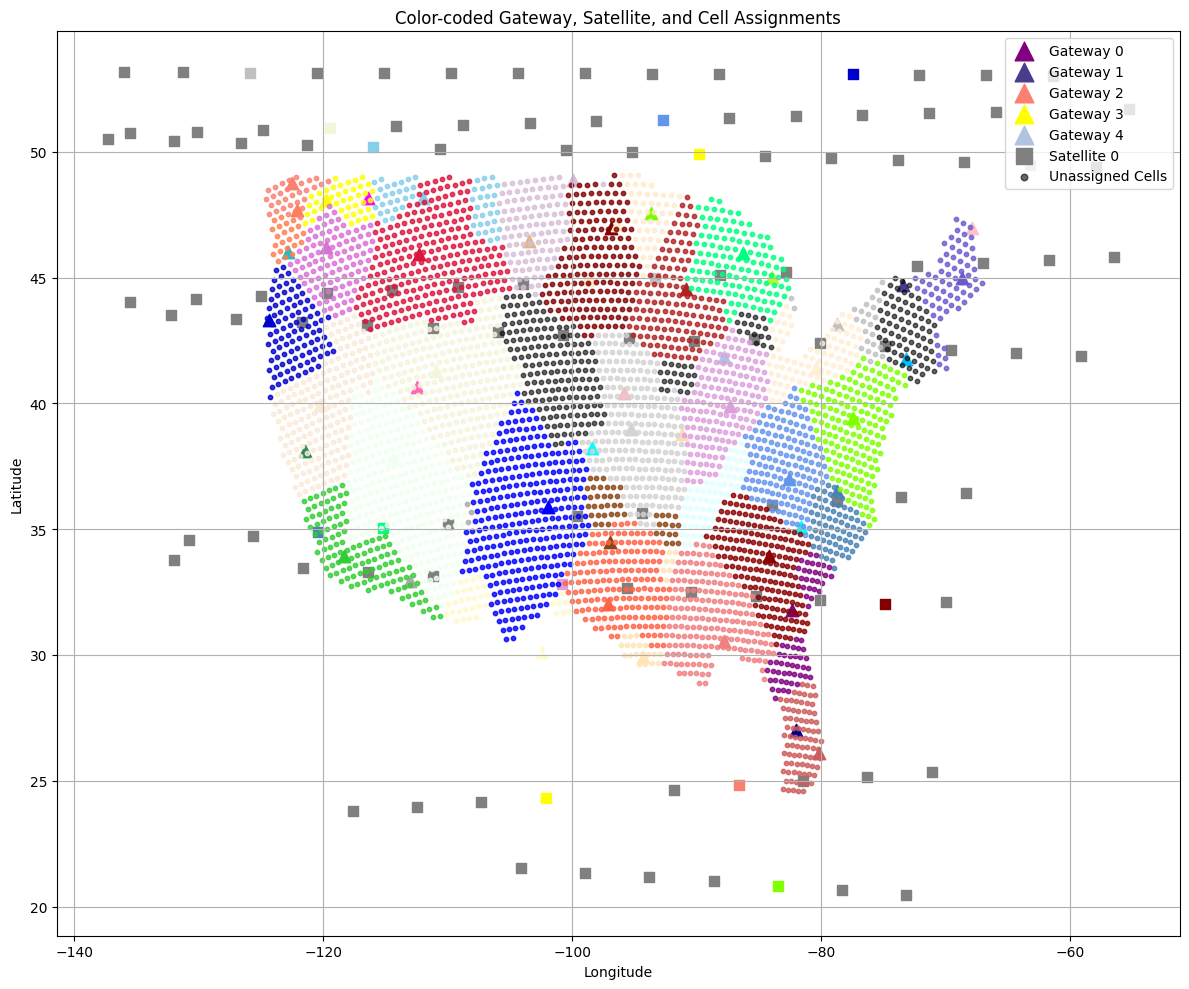

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# === Load Data ===
mapping_df = pd.read_csv("satellite_to_cells_mapping.csv")
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv")
sat_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv")
sat_df = sat_df.drop_duplicates(subset='feed_sat')

# === Build Gateway Color Map ===
NUM_GATEWAYS = 54
gateway_ids = list(range(NUM_GATEWAYS))
color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
np.random.seed(42)  # for consistent color shuffling
np.random.shuffle(color_list)
gateway_color_map = {gw: color_list[i % len(color_list)] for i, gw in enumerate(gateway_ids)}

# === Track used cells
assigned_cell_indices = set()
satellite_colors = {}  # satellite_id -> color (based on gateway)
cell_color_data = []   # (lng, lat, color)

# === Assign colors to cells and satellites ===
for _, row in mapping_df.iterrows():
    gateway = row['predicted_gateway']
    sat_id = row['unique_satellite_id']
    color = gateway_color_map.get(gateway, 'gray')
    satellite_colors[sat_id] = color

    if isinstance(row['assigned_cells'], str):
        cell_indices = eval(row['assigned_cells'])
    else:
        cell_indices = []

    assigned_cell_indices.update(cell_indices)

    for idx in cell_indices:
        lat, lng = cells_df.loc[idx, ['lat', 'lng']]
        cell_color_data.append((lng, lat, color))

# === Unassigned cells ===
all_cell_indices = set(cells_df.index)
unassigned_cells = cells_df.loc[list(all_cell_indices - assigned_cell_indices)]

# === Plot ===
plt.figure(figsize=(12, 10))

# 1. Gateways (colored triangles)
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), s=80, label=f"Gateway {gw_id}" if gw_id < 5 else "")

# 2. Satellites (colored squares)
for i, row in sat_df.iterrows():
    sat_id = i
    lat, lng = row['Latitude'], row['Longitude']
    color = satellite_colors.get(sat_id, 'gray')
    plt.scatter(lng, lat, marker='s', c=color, s=60, label=f"Satellite {sat_id}" if sat_id < 1 else "")

# 3. Cells (colored circles)
for lng, lat, color in cell_color_data:
    plt.scatter(lng, lat, color=color, s=10, alpha=0.8)

# 4. Unassigned Cells (black circles)
plt.scatter(unassigned_cells['lng'], unassigned_cells['lat'], color='black',
            s=10, alpha=0.6, label="Unassigned Cells")

# === Aesthetics ===
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Color-coded Gateway, Satellite, and Cell Assignments")
plt.grid(True)
plt.legend(loc='upper right', markerscale=1.5)
plt.tight_layout()

# === Save & Show ===
plt.savefig("color_coded_satellite_gateway_cell_map.png", dpi=300)
plt.show()


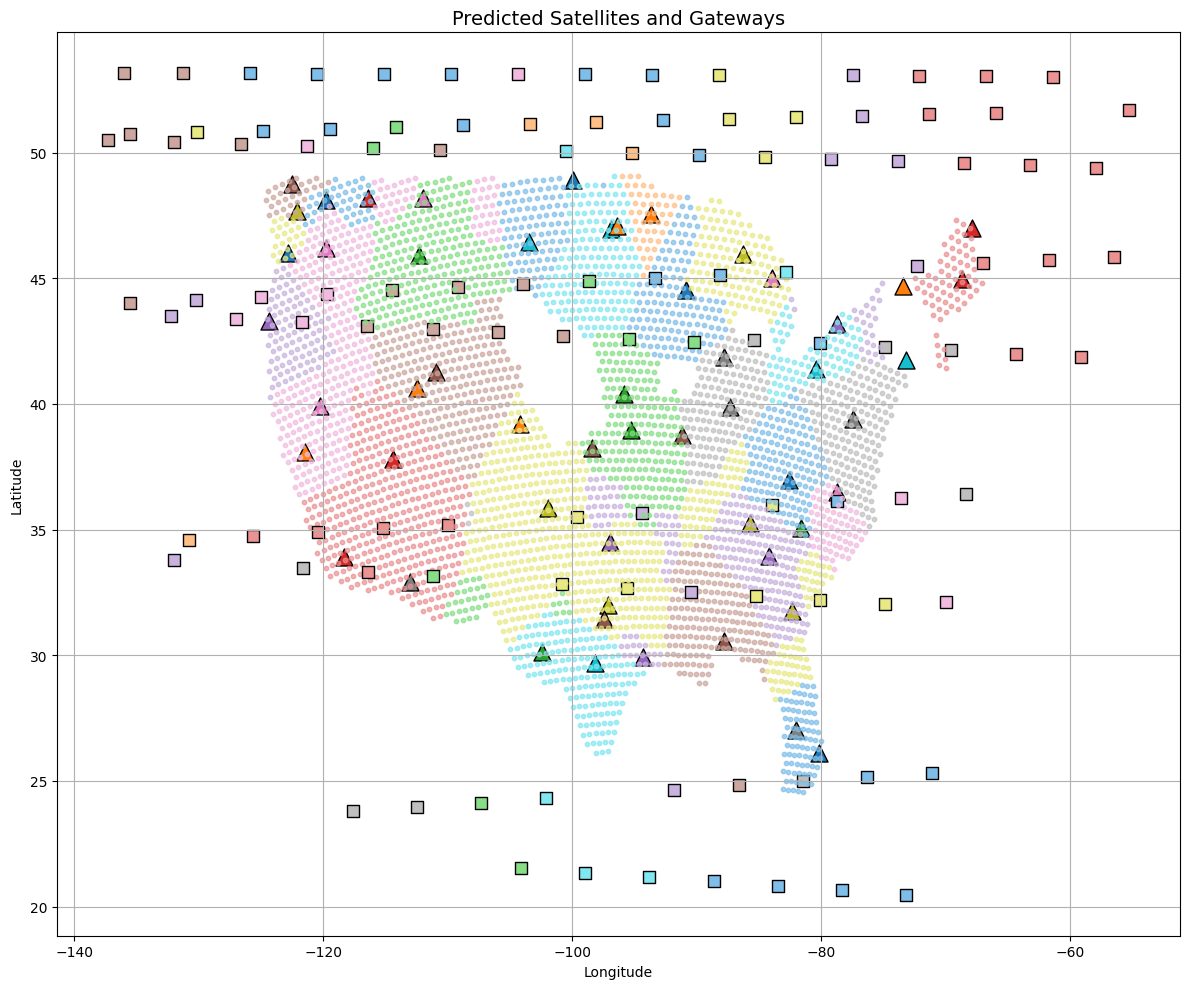

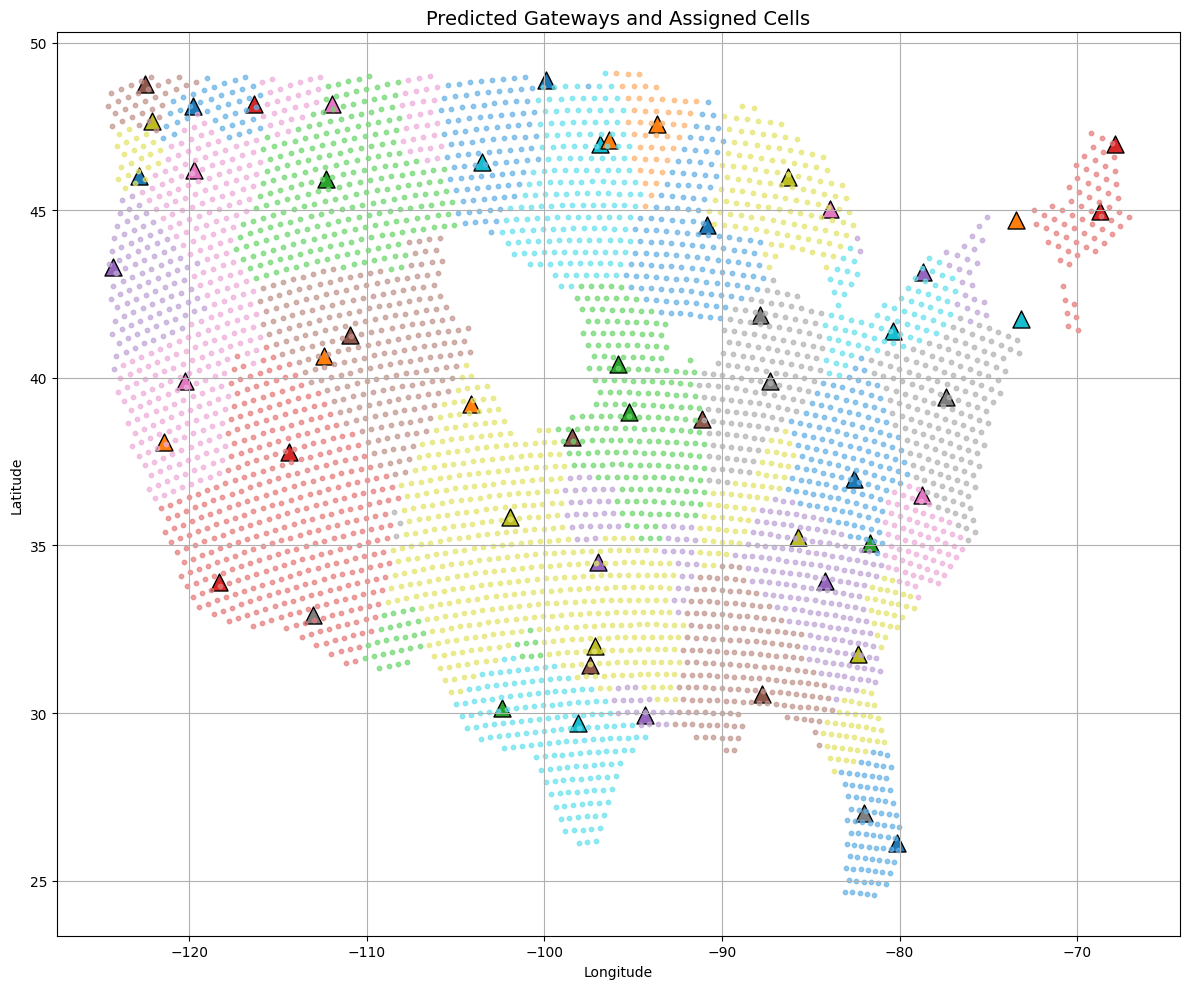

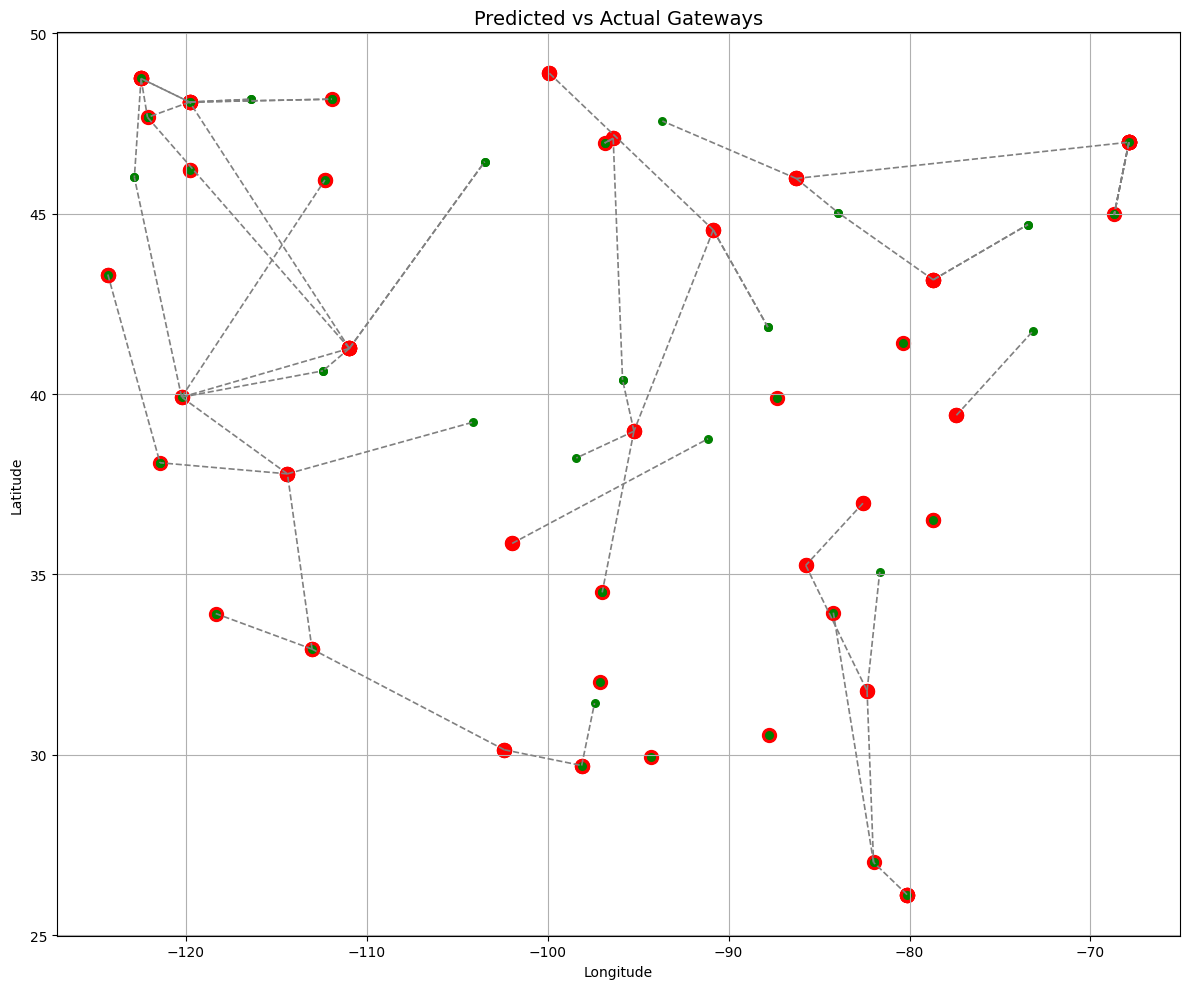

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# === Load Data ===
mapping_df = pd.read_csv("satellite_to_cells_mapping.csv")
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv")
sat_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv")
sat_df = sat_df.drop_duplicates(subset='feed_sat')

# === Setup Color Map ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)

gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

# === Helper: Lighter version of color ===
def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    r, g, b = colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)
    return r, g, b

# === Parse list-like column ===
def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

mapping_df['assigned_cells'] = mapping_df['assigned_cells'].apply(parse_cells)

# === Map 1: Predicted Satellites & Gateways ===
plt.figure(figsize=(12, 10))
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=150)

for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    sat_id = row['unique_satellite_id']
    color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.5)
    sat_row = sat_df[sat_df['feed_sat'] == sat_id]
    if not sat_row.empty:
        lng, lat = sat_row.iloc[0][['Longitude', 'Latitude']]
        plt.scatter(lng, lat, marker='s', c=[color], edgecolor='black', s=80)

    for cell_idx in row['assigned_cells']:
        lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
        plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

plt.title("Predicted Satellites and Gateways", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map1_predicted_satellites_and_gateways.png", dpi=300)
plt.show()

# === Map 2: Predicted Gateways & Assigned Cells ===
plt.figure(figsize=(12, 10))
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=150)

for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.4)
    for cell_idx in row['assigned_cells']:
        lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
        plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

plt.title("Predicted Gateways and Assigned Cells", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map2_predicted_gateways_and_cells.png", dpi=300)
plt.show()

# === Map 3: Predicted vs Actual Gateways ===
plt.figure(figsize=(12, 10))
for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    actual_gw = row['actual_gateway_id']

    pred_gw_row = gw_df[gw_df['gw_id'] == pred_gw]
    actual_gw_row = gw_df[gw_df['gw_id'] == actual_gw]

    if not pred_gw_row.empty and not actual_gw_row.empty:
        pred_lng, pred_lat = pred_gw_row.iloc[0][['longitude', 'latitude']]
        act_lng, act_lat = actual_gw_row.iloc[0][['longitude', 'latitude']]

        plt.scatter(pred_lng, pred_lat, color='red', s=100, label='Predicted Gateway')
        plt.scatter(act_lng, act_lat, color='green', s=30, label='Actual Gateway')
        plt.plot([pred_lng, act_lng], [pred_lat, act_lat], linestyle='--', color='gray', linewidth=1.2)

plt.title("Predicted vs Actual Gateways", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map3_predicted_vs_actual_gateways.png", dpi=300)
plt.show()


5 files

In [33]:
import os
import glob
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model import Stage2GNN

# === Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model.pth'

# === Load Base Data ===
cells_df = pd.read_csv(cells_path)
total_cells = len(cells_df)
all_cell_indices = set(cells_df.index)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === File Selection ===
all_files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))
selected_files = all_files[:8]  # pick first 5

# === Global Trackers ===
global_covered_cells = set()
coverage_results = []

# === Loop Over Files ===
for file_num, data_file in enumerate(selected_files, start=1):
    print(f"\n=== Processing File {file_num}: {os.path.basename(data_file)} ===")

    original_df = pd.read_csv(data_file)
    unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
    feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
    sat_to_indices = defaultdict(list)
    for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
        sat_to_indices[feed_sat].append(row_idx)

    satellite_to_gateway = {}
    gateway_to_sats = defaultdict(list)
    cell_to_gateways = {}
    for idx, row in cells_df.iterrows():
        cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

    graph = build_graph_from_file(data_file)
    data_loader = DataLoader([graph], batch_size=1)

    # === Model Inference ===
    top1_preds = []
    with torch.no_grad():
        for data in data_loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

            binary_preds = np.zeros_like(stage1_preds)
            for i, idx in enumerate(top3_indices):
                binary_preds[i, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
            gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
            top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

            for row_idx, gateway in enumerate(top1_preds):
                feed_sat = original_df.iloc[row_idx]["feed_sat"]
                satellite_to_gateway[feed_sat] = gateway
                gateway_to_sats[gateway].append(feed_sat)

    # === Fair Cell Assignment ===
    satellite_to_cells = defaultdict(list)
    assigned_cells = set()
    used_gateways = set()

    for gw, sats in gateway_to_sats.items():
        nearby_cells = cells_df[
            (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
        ].index.tolist()

        if not sats or not nearby_cells:
            continue

        used_gateways.add(gw)
        sats = list(set(sats))
        n_sats = len(sats)
        cell_chunks = np.array_split(nearby_cells, n_sats)

        for sat, chunk in zip(sats, cell_chunks):
            for cell in chunk:
                if cell not in assigned_cells:
                    satellite_to_cells[sat].append(cell)
                    assigned_cells.add(cell)

    # === Track global coverage ===
    global_covered_cells.update(assigned_cells)
    file_coverage = len(assigned_cells) / total_cells * 100

    # === Summary ===
    total_unique_sats = len(unique_sats)
    assigned_sat_ids = set(satellite_to_cells.keys())
    unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
    all_gateways = set(range(NUM_GATEWAYS))
    unused_gateways = sorted(all_gateways - used_gateways)
    unassigned_cells = sorted(all_cell_indices - assigned_cells)

    print(f"Unique Satellites: {total_unique_sats}")
    print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({file_coverage:.2f}% coverage)")
    print(f"Used Gateways: {len(used_gateways)} / {NUM_GATEWAYS}")
    print(f"Unassigned Cells: {len(unassigned_cells)}")
    
    coverage_results.append({
        "file": os.path.basename(data_file),
        "assigned_cells": len(assigned_cells),
        "coverage_percent": file_coverage
    })

    # === Optional: Export per-file results ===
    output_rows = []
    all_sat_ids = sorted(feed_sat_to_id.keys())
    for sat_feed_val in all_sat_ids:
        row_indices = sat_to_indices.get(sat_feed_val, [])
        predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
        most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
        assigned = satellite_to_cells.get(sat_feed_val, [])
        assigned_clean = [int(cell) for cell in assigned]
        actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
        actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

        output_rows.append({
            "unique_satellite_id": sat_feed_val,
            "predicted_gateway": most_common_gateway,
            "actual_gateway_id": actual_gateway,
            "assigned_cells": assigned_clean,
            "actual_cell_ids": actual_cell_ids
        })

    output_df = pd.DataFrame(output_rows)
    output_csv_path = f"satellite_to_cells_mapping_file{file_num}.csv"
    output_df.to_csv(output_csv_path, index=False)

# === Global Coverage Summary ===
print("\n=== Global Summary Across 5 Files ===")
print(f"Total Unique Cells: {total_cells}")
print(f"Cells Covered In Any File: {len(global_covered_cells)}")
print(f"Overall Coverage: {len(global_covered_cells) / total_cells * 100:.2f}%")

global_unassigned_cells = sorted(all_cell_indices - global_covered_cells)


# === Print Per-File Coverage ===
print("\n=== Per-File Coverage Stats ===")
for result in coverage_results:
    print(f"{result['file']}: {result['assigned_cells']} cells covered ({result['coverage_percent']:.2f}%)")
# === Unassigned Cells Across All 5 Files ===
global_unassigned_cells = sorted(all_cell_indices - global_covered_cells)

print("\n=== Cells Never Assigned in Any of the 5 Files ===")
print(f"Total Unassigned Cells: {len(global_unassigned_cells)}")

print(f"Sample Unassigned Cell Indices: {global_unassigned_cells[:20]}")

# Optional: Save to CSV
unassigned_df = cells_df.loc[global_unassigned_cells].copy()
unassigned_df.to_csv("unassigned_cells_across_5_files.csv", index=False)
print("→ Unassigned cell info saved to: unassigned_cells_across_5_files.csv")



=== Processing File 1: file_data_00_00_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 112
Assigned Cells: 4296 / 4569 (94.02% coverage)
Used Gateways: 39 / 54
Unassigned Cells: 273

=== Processing File 2: file_data_00_00_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 108
Assigned Cells: 4504 / 4569 (98.58% coverage)
Used Gateways: 45 / 54
Unassigned Cells: 65

=== Processing File 3: file_data_00_00_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4306 / 4569 (94.24% coverage)
Used Gateways: 41 / 54
Unassigned Cells: 263

=== Processing File 4: file_data_00_01_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 106
Assigned Cells: 4334 / 4569 (94.86% coverage)
Used Gateways: 42 / 54
Unassigned Cells: 235

=== Processing File 5: file_data_00_01_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 106
Assigned Cells: 4176 / 4569 (91.40% coverage)
Used Gateways: 40 / 54
Unassigned Cells: 393

=== Processing File 6: file_data_00_01_40.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4210 / 4569 (92.14% coverage)
Used Gateways: 39 / 54
Unassigned Cells: 359

=== Processing File 7: file_data_00_02_00.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 109
Assigned Cells: 4528 / 4569 (99.10% coverage)
Used Gateways: 45 / 54
Unassigned Cells: 41

=== Processing File 8: file_data_00_02_20.csv ===


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Unique Satellites: 107
Assigned Cells: 4487 / 4569 (98.21% coverage)
Used Gateways: 44 / 54
Unassigned Cells: 82

=== Global Summary Across 5 Files ===
Total Unique Cells: 4569
Cells Covered In Any File: 4552
Overall Coverage: 99.63%

=== Per-File Coverage Stats ===
file_data_00_00_00.csv: 4296 cells covered (94.02%)
file_data_00_00_20.csv: 4504 cells covered (98.58%)
file_data_00_00_40.csv: 4306 cells covered (94.24%)
file_data_00_01_00.csv: 4334 cells covered (94.86%)
file_data_00_01_20.csv: 4176 cells covered (91.40%)
file_data_00_01_40.csv: 4210 cells covered (92.14%)
file_data_00_02_00.csv: 4528 cells covered (99.10%)
file_data_00_02_20.csv: 4487 cells covered (98.21%)

=== Cells Never Assigned in Any of the 5 Files ===
Total Unassigned Cells: 17
Sample Unassigned Cell Indices: [294, 341, 972, 1185, 1821, 2225, 2382, 2458, 2666, 2827, 2861, 3039, 3054, 3255, 3381, 3474, 4073]
→ Unassigned cell info saved to: unassigned_cells_across_5_files.csv


In [34]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# === Base Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
gw_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv"

# === Load Static Data ===
cells_df = pd.read_csv(cells_path)
gw_df = pd.read_csv(gw_path)

NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

# === Helpers ===
def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    r, g, b = colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)
    return r, g, b

def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

def get_time_filename(index):
    total_seconds = index * 20
    hh = total_seconds // 3600
    mm = (total_seconds % 3600) // 60
    ss = total_seconds % 60
    return f"file_data_{hh:02d}_{mm:02d}_{ss:02d}.csv"

# === Load Mapping Files ===
mapping_files = sorted(glob.glob("satellite_to_cells_mapping_file*.csv"))
selected_files = mapping_files[:5]

for idx, mapping_path in enumerate(selected_files):
    file_num = idx + 1
    print(f"\n=== Generating Maps for File {file_num} ===")

    # Load mapping + satellite file
    mapping_df = pd.read_csv(mapping_path)
    mapping_df['assigned_cells'] = mapping_df['assigned_cells'].apply(parse_cells)

    sat_file_name = get_time_filename(idx)
    sat_file_path = os.path.join(folder_path, sat_file_name)

    if not os.path.exists(sat_file_path):
        print(f"⚠️ Satellite file not found: {sat_file_path}")
        continue

    sat_df = pd.read_csv(sat_file_path).drop_duplicates(subset='feed_sat')

    # === Map 1: Predicted Satellites & Gateways ===
    plt.figure(figsize=(12, 10))
    for _, row in gw_df.iterrows():
        plt.scatter(row['longitude'], row['latitude'], marker='^',
                    color=gateway_color_map.get(row['gw_id'], 'gray'), s=150, edgecolors='k')

    for _, row in mapping_df.iterrows():
        pred_gw = row['predicted_gateway']
        sat_id = row['unique_satellite_id']
        color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.5)

        sat_row = sat_df[sat_df['feed_sat'] == sat_id]
        if not sat_row.empty:
            lng, lat = sat_row.iloc[0][['Longitude', 'Latitude']]
            plt.scatter(lng, lat, marker='s', c=[color], edgecolors='k', s=80)

        for cell_idx in row['assigned_cells']:
            lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
            plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

    plt.title(f"Map 1 - Predicted Satellites and Gateways (File {file_num})", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"map1_file{file_num}_predicted_satellites_and_gateways.png", dpi=300)
    plt.close()

    # === Map 2: Predicted Gateways & Assigned Cells ===
    plt.figure(figsize=(12, 10))
    for _, row in gw_df.iterrows():
        plt.scatter(row['longitude'], row['latitude'], marker='^',
                    color=gateway_color_map.get(row['gw_id'], 'gray'), s=150, edgecolors='k')

    for _, row in mapping_df.iterrows():
        pred_gw = row['predicted_gateway']
        color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.4)
        for cell_idx in row['assigned_cells']:
            lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
            plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

    plt.title(f"Map 2 - Predicted Gateways and Cells (File {file_num})", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"map2_file{file_num}_predicted_gateways_and_cells.png", dpi=300)
    plt.close()

    # === Map 3: Predicted vs Actual Gateways ===
    plt.figure(figsize=(12, 10))
    for _, row in mapping_df.iterrows():
        pred_gw = row['predicted_gateway']
        actual_gw = row['actual_gateway_id']

        pred_gw_row = gw_df[gw_df['gw_id'] == pred_gw]
        actual_gw_row = gw_df[gw_df['gw_id'] == actual_gw]

        if not pred_gw_row.empty and not actual_gw_row.empty:
            pred_lng, pred_lat = pred_gw_row.iloc[0][['longitude', 'latitude']]
            act_lng, act_lat = actual_gw_row.iloc[0][['longitude', 'latitude']]

            plt.scatter(pred_lng, pred_lat, color='red', s=100)
            plt.scatter(act_lng, act_lat, color='green', s=30)
            plt.plot([pred_lng, act_lng], [pred_lat, act_lat], linestyle='--', color='gray', linewidth=1.2)

    plt.title(f"Map 3 - Predicted vs Actual Gateways (File {file_num})", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"map3_file{file_num}_predicted_vs_actual_gateways.png", dpi=300)
    plt.close()

print("\nAll maps generated for selected files.")



=== Generating Maps for File 1 ===

=== Generating Maps for File 2 ===

=== Generating Maps for File 3 ===

=== Generating Maps for File 4 ===

=== Generating Maps for File 5 ===

All maps generated for selected files.


Check stage 1 model

In [4]:
import os
import numpy as np
import pandas as pd
import ast
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Load model and scaler
STAGE1_MODEL_PATH = 'stage_1_model.h5'
SCALER_PATH = 'stage_1_scaler.pkl'
stage1_model = load_model(STAGE1_MODEL_PATH)

with open(SCALER_PATH, 'rb') as f:
    scaler = pickle.load(f)

NUM_GATEWAYS = 54
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"

def parse_matrix(matrix_str):
    try:
        return np.array(ast.literal_eval(str(matrix_str)), dtype=np.float32)
    except Exception:
        return np.zeros(NUM_GATEWAYS, dtype=np.float32)

# Load 10 test files
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])
test_files = file_list[100:110]

top1_correct = 0
top3_correct = 0
top5_correct = 0
total = 0

for file in test_files:
    df = pd.read_csv(file, usecols=['Latitude', 'Longitude', 'Altitude', 'visible_gateway_matrix', 'optimal_gateway_matrix'])
    df['visible_gateway_matrix'] = df['visible_gateway_matrix'].apply(parse_matrix)
    df['optimal_gateway_matrix'] = df['optimal_gateway_matrix'].apply(parse_matrix)

    positions = df[['Latitude', 'Longitude', 'Altitude']].values
    visible = np.vstack(df['visible_gateway_matrix'].values)
    X = np.hstack([positions, visible])
    X = scaler.transform(X)  # ✅ Just transform, don't fit again

    y_true = np.argmax(np.vstack(df['optimal_gateway_matrix'].values), axis=1)

    preds = stage1_model.predict(X, verbose=0)
    top1 = np.argmax(preds, axis=1)
    top3 = np.argsort(preds, axis=1)[:, -3:]
    top5 = np.argsort(preds, axis=1)[:, -5:]

    for i in range(len(y_true)):
        true = y_true[i]
        total += 1
        if top1[i] == true:
            top1_correct += 1
        if true in top3[i]:
            top3_correct += 1
        if true in top5[i]:
            top5_correct += 1

# Results
print("\n===== STAGE 1 MODEL ACCURACY =====")
print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"Top-3 Accuracy: {top3_correct / total:.4f}")
print(f"Top-5 Accuracy: {top5_correct / total:.4f}")




===== STAGE 1 MODEL ACCURACY =====
Top-1 Accuracy: 0.4505
Top-3 Accuracy: 0.7569
Top-5 Accuracy: 0.9003


check for various epochs and rounds

In [ ]:
import os
import torch
import torch.optim as optim
from tensorflow.keras.models import load_model
from torch_geometric.loader import DataLoader as PyGDataLoader
import pandas as pd
import numpy as np

from dataloader import SatelliteDataset, NUM_GATEWAYS
from model import Stage2GNN
from train import train_model_with_mse
from utils import top_k_accuracy, prepare_input_for_gnn
from dataloader import build_graph_from_file

# === Paths ===
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
RESULTS_DIR = "gnn_sweep_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

STAGE1_MODEL_PATH = 'stage_1_model.h5'
stage1_model = load_model(STAGE1_MODEL_PATH)

# === Load Data ===
file_list = sorted([
    os.path.join(DATA_FOLDER, f)
    for f in os.listdir(DATA_FOLDER)
    if f.endswith('.csv')
])[:20]

train_size = int(0.8 * len(file_list))
train_files, val_files = file_list[:train_size], file_list[train_size:]

train_dataset = SatelliteDataset(train_files)
val_dataset = SatelliteDataset(val_files)

train_loader = PyGDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=16, shuffle=False)

# === Test Files for Evaluation ===
test_files = file_list[train_size:]
test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
test_loader = PyGDataLoader(test_graphs, batch_size=1, shuffle=False)

# === Sweep Config ===
epoch_options = [5, 10, 15]
round_options = [2, 4, 8, 16]

for epochs in epoch_options:
    print(f"\n🚀 Training GNN: Epochs={epochs}")

    gnn_model = Stage2GNN(
        input_dim=3 + NUM_GATEWAYS * 3,
        sat_feature_dim=111,
        neighbor_feature_dim=NUM_GATEWAYS,
        hidden_dim=256,
        output_dim=NUM_GATEWAYS,
        dropout=0.3,
        use_residual=True
    )
    optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)

    # Train once
    train_model_with_mse(
        gnn_model=gnn_model,
        stage1_model=stage1_model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer_gnn=optimizer,
        num_epochs=epochs,
        rounds=round_options[-1]  # Just use max rounds in training
    )

    for rounds in round_options:
        gnn_model.eval()
        total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0

        with torch.no_grad():
            for data in test_loader:
                input_features = data.x[:, :57].cpu().numpy()
                stage1_preds = stage1_model.predict(input_features, verbose=0)
                top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

                binary_preds_model1 = np.zeros_like(stage1_preds)
                for i, idx in enumerate(top3_model1):
                    binary_preds_model1[i, idx] = 1

                gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))

                for _ in range(rounds):
                    preds = gnn_model(gnn_input.x, gnn_input.edge_index)
                    top3_gnn = torch.topk(preds, k=3, dim=1).indices
                    gnn_input = prepare_input_for_gnn(data, top3_gnn)

                total_top1 += top_k_accuracy(preds, data.y, k=1)
                total_top3 += top_k_accuracy(preds, data.y, k=3)
                total_top5 += top_k_accuracy(preds, data.y, k=5)
                total_samples += 1

        # Save model & accuracy for this round
        model_path = os.path.join(RESULTS_DIR, f"GNN_epoch_{epochs}_rounds_{rounds}.pth")
        torch.save(gnn_model.state_dict(), model_path)

        acc_top1 = total_top1 / total_samples
        acc_top3 = total_top3 / total_samples
        acc_top5 = total_top5 / total_samples

        metrics_file = os.path.join(RESULTS_DIR, f"GNN_epoch_{epochs}_rounds_{rounds}.txt")
        with open(metrics_file, "w") as f:
            f.write(f"Top-1 Accuracy: {acc_top1:.4f}\n")
            f.write(f"Top-3 Accuracy: {acc_top3:.4f}\n")
            f.write(f"Top-5 Accuracy: {acc_top5:.4f}\n")

        print(f"✅ Saved: {model_path} & Accuracies to {metrics_file}")



🚀 Training GNN: Epochs=5
Epoch 2, Train Loss: 3.8821, Val Loss: 3.8198
